# Face Recognition using Siamese Networks

This project incorporates the SiameseNet Face Recognition architecture proposed by Gregory Koch et al. from the University of Toronto in their seminal paper *Siamese Neural Networks for One-shot Image Recognition*. Although these authors are not the inventors of the Siamese Network architecture itself, their work was instrumental in incorporating it into One-Shot learning scenarios - scenarios that require the classification of an image given only one chance ("shot"). Such is the case of Face Recognition situations, where the algorithm has to go off a single image of a person's face given just before expected inference time.

We reproduce the architecture by following Nicholas Renotte's guided project (https://youtu.be/LKispFFQ5GU?si=aAZQ7dpjRUWWvsei), but we substantially expand upon it by adding an image augmentation pipeline, replacing standard Categorical Cross Entropy Loss with Triplet Loss, and fine-tuning the model for optimal performance on a very small dataset.

**Note: even though Face Recognition refers to a 1:N problem (matching one input identity to an identity among N identities in the database), we implement the architecture so as to solve a 1:1 problem (matching one input identity to one identity in the database). Thus, we will in fact be incorporating a Face Verification, rather than Face Recognition, solution. You could also say we're solving a 1:N problem with N=1.**

## Siamese Neural Network Architecture

The Architecture of the SiameseNet network is quite straight-forward. From left to right, it consists of two branches. One branch (say, the top one), is tasked with encoding the features of an input *anchor* image, and the other with encoding the *positive* or *negative* image. As will be mentioned afterwards, this is done by using a typical Convolutional block (i.e. Conv2D, MaxPool2D and similar layers).

After the images have their features encoded, the two streams are joined into a single Distance Layer whose task it is to adjust its weight and bias parameters such that the Eucledian distance in the feature space between:

1.) the ***anchor*** image and the ***positive*** image be as **small** as possible (more precisely, below a certain threshold); <br>
2.) the ***anchor*** image and the ***negative*** image be as **large** as possible.

Keep in mind that, when using regular Binary Cross Entropy Loss ("Tuplet" Loss), training data is passed in tuplets of [anchor, positive/negative, label(0 or 1)]. But, when using **Triplet Loss**, they are passed as triplets [(anchor, positive, negative, label(0 or 1)].

Weights (same for both branches) adjusted to satisfy conditions 1.) and 2.) will be sure to perform well on the task of classifying single-instance images as either positive or negative relative to the anchor class. This is what Face Recognition really is.

Finally, the output layer is a simple sigmoid activation that outputs either 1 (person on input image is the person on anchor image) or 0 (person on input image is not the person on anchor image).

![image.png](images/architecture.jpeg)

Triplet Loss Function definition:

![image.png](images/triplet_loss.svg)

where:

$A^{(i)}$ are the encodings of the Anchor class; <br>
$P^{(i)}$ are the encodings of the Positive class; <br>
$N^{(i)}$ are the encodings of the Negative class.

If A, P, N are images taken randomly, it is usually not difficult to find weights that satisfy conditions 1.) and 2.). Since this can lead to poorer generalization, Hard Triplets are introduced. They are, simply speaking, (A, P, N) triplets of images that are more similiar to one another, making their demarcation more difficult. These "hard cases" make the model more robust and allow it to generalize better in the wild.

## Defining workspace

### Importing libraries

In [165]:
#Importing libraries
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import uuid
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten, Lambda

### Setting up GPU growth limit

In [166]:
#Setting up GPU growth limit to prevent Out Of Memory (OOM) errors
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

### Setting up Paths

In [167]:
#Setting up paths 
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

LFW_PATH = 'lfw-deepfunneled'

#Creating folder structures
try:
    os.makedirs(POS_PATH)
    os.makedirs(NEG_PATH)
    os.makedirs(ANC_PATH)
except FileExistsError:
    print("Directories already exist!")

Directories already exist!


### Loading LFW (*Labeled Faces in the Wild*) Image Data

In [ ]:
#Fetching negatives (LFW Dataset)
!tar -xf lfw-deepfunneled/lfw-deepfunneled.tar

tar: Error opening archive: Failed to open 'lfw-deepfunneled/lfw-deepfunneled.tar'


In [12]:
#Move LFW Images to Negatives 
try:
  for directory in os.listdir(LFW_PATH):
    for filee in os.listdir(os.path.join(LFW_PATH, directory)):
      EX_PATH = os.path.join(LFW_PATH, directory, filee)
      NEW_PATH = os.path.join(NEG_PATH, filee)
      os.replace(EX_PATH, NEW_PATH)

    print(f"Successfully moved LFW images to {NEG_PATH}.")
except:
  print("An error occured!")

Successfully moved LFW images to data\negative.
Successfully moved LFW images to data\negative.
Successfully moved LFW images to data\negative.
Successfully moved LFW images to data\negative.
Successfully moved LFW images to data\negative.
Successfully moved LFW images to data\negative.
Successfully moved LFW images to data\negative.
Successfully moved LFW images to data\negative.
Successfully moved LFW images to data\negative.
Successfully moved LFW images to data\negative.
Successfully moved LFW images to data\negative.
Successfully moved LFW images to data\negative.
Successfully moved LFW images to data\negative.
Successfully moved LFW images to data\negative.
Successfully moved LFW images to data\negative.
Successfully moved LFW images to data\negative.
Successfully moved LFW images to data\negative.
Successfully moved LFW images to data\negative.
Successfully moved LFW images to data\negative.
Successfully moved LFW images to data\negative.
Successfully moved LFW images to data\ne

The LFW dataset is a dataset that consists of a large number of images containing faces. In the context of this project, LFW images will be used as the Negative components for trianing the Siamese Network.

### Collecting Anchor and Positive images using Webcam (CV2)

In [30]:
#Collect positive and anchor classes using webcam
#Establish connection to webcam
cap = cv2.VideoCapture(0)

while cap.isOpened():
  #Read results
  ret, frame = cap.read()
  #Clipping frame to relevant size (250x250)
  frame = frame[120:120+250, 200:200+250]
  #Collecting anchors
  if cv2.waitKey(1) & 0XFF == ord('a'):
    #Create unique file path
    imgname = os.path.join(ANC_PATH, f'{uuid.uuid1()}.jpg')
    #Write anchor image to folder
    cv2.imwrite(imgname, frame)

  #Collecting positives
  if cv2.waitKey(1) & 0XFF == ord('p'):
    #Create unique file path
    imgname = os.path.join(POS_PATH, f'{uuid.uuid1()}.jpg')
    #Write anchor image to folder
    cv2.imwrite(imgname, frame)

  #Show image back to screen
  cv2.imshow('Image Collection', frame)
  
  #Breaking if appropriate key is pressed
  if cv2.waitKey(1) & 0XFF == ord('q'):
    break

#Release webcam
cap.release()
#Close .imshow() frame
cv2.destroyAllWindows

<function destroyAllWindows>

Upon executing the above code, a webcam window will appear and allow us to capture and store an Anchor image by pressing the ```a``` key on the keyboard. Similarly, by pressing ```p```, we can capture a Positive image. These images will be essential for the training of the Siamese Net.

In this project, we will use around 300 Anchor and 300 Positive images, but we will take more just in case.

Finally, pressing ```q``` allows us to close the webcam window.

#### Anchor Image (example)

![Anchor](data\anchor\ad8ff2a0-1ea5-11f0-9e77-04ed33d22284.jpg)

#### Positive Image (example)

![positive](data/positive/2f3d5e47-1ea6-11f0-a787-04ed33d22284.jpg)

Absolutely beautiful.

## Data Augmentation and Preprocessing

In [170]:
#Defining image augmentation and preprocessing function

def preprocess(file_path, augment=False): # Add augment flag
    # Loading
    byte_img = tf.io.read_file(file_path)
    # Explicitly decode as 3 channels (RGB)
    img = tf.io.decode_jpeg(byte_img, channels=3)
    # Resizing to 105x105 (make sure this size is used consistently)
    img = tf.image.resize(img, (105, 105))
    # Scaling
    img = img / 255.0

    # Apply augmentation conditionally
    if augment:
        img = augment_image(img)

    # Explicitly set the shape - this helps tf.data understand the output
    img.set_shape((105, 105, 3))

    return img

# The preprocess_triplet function remains the same:
def preprocess_triplet(anchor_path, positive_path, negative_path, augment=False):
    return (
        preprocess(anchor_path, augment),
        preprocess(positive_path, augment),
        preprocess(negative_path, augment)
    )

# The augment_image function remains the same:
def augment_image(img):
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, max_delta=0.2)
    img = tf.clip_by_value(img, 0.0, 1.0)
    return img


#Function for image preprocessing before inference
def preprocess_for_inference(file_path):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img, channels=3)
    img = tf.image.resize(img, (105, 105))
    img = img / 255.0
    img = np.expand_dims(img, axis=0) # Add batch dimension
    return img

### Creating Data Pipeline

In [171]:
#Getting lists of file paths
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(3000)

#Creating labeled datasets
positives_anc = tf.data.Dataset.zip((anchor, positive))
negative_repeated = negative.repeat(len(anchor))

#Combining to form triplets ((anchor, positive), negative)
triplet_dataset_paths = tf.data.Dataset.zip((positives_anc, negative_repeated))
#Flattening structure to: (anchor, positive, negative)
triplet_dataset_paths = triplet_dataset_paths.map(lambda x,y: (x[0], x[1], y))

#Setting buffer and batch size
BUFFER_SIZE = int(len(anchor) * 0.7)
BATCH_SIZE = 16

#Splitting data
DATASET_SIZE = len(anchor)
TRAIN_SIZE = int(0.85 * DATASET_SIZE)
TEST_SIZE = DATASET_SIZE - TRAIN_SIZE

#Shuffling paths before splitting and preprocessing
triplet_dataset_paths = triplet_dataset_paths.shuffle(buffer_size=BUFFER_SIZE)

#Training Data Pipeline
train_data = triplet_dataset_paths.take(TRAIN_SIZE)
#Applying preprocessing with augmentation for training
train_data = train_data.map(lambda a, p, n: preprocess_triplet(a, p, n, augment=True), num_parallel_calls=tf.data.AUTOTUNE)
train_data = train_data.cache() # Caching
train_data = train_data.shuffle(buffer_size=BUFFER_SIZE)
train_data = train_data.batch(BATCH_SIZE)
train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE)

#Test Data Pipeline (no augmentation)
test_data = triplet_dataset_paths.skip(TRAIN_SIZE)
# Applying preprocessing WITHOUT augmentation for testing
test_data = test_data.map(lambda a, p, n: preprocess_triplet(a, p, n, augment=False), num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.cache() # Cache after preprocessing
test_data = test_data.batch(BATCH_SIZE) # Batch size can be larger for testing if memory allows
test_data = test_data.prefetch(buffer_size=tf.data.AUTOTUNE)

print(f"Dataset Size: {DATASET_SIZE}")
print(f"Train Size: {TRAIN_SIZE}, Test Size: {TEST_SIZE}")
print(f"Train Batches: {len(train_data)}, Test Batches: {len(test_data)}")


Dataset Size: 300
Train Size: 255, Test Size: 45
Train Batches: 16, Test Batches: 3


## SiameseNet Model

### Embedding Layer

In [172]:
def make_embedding_layer():
    input_shape = (105, 105, 3) # Adjusted input shape
    input_tensor = Input(shape=input_shape, name='input_image')

    # --- Convolutional Blocks (Based on original structure) ---
    # Block 1
    x = Conv2D(64, (10, 10), activation='relu', name='conv1_1')(input_tensor)
    x = MaxPooling2D((2, 2), padding='same', name='pool1')(x) # Corrected pool_size

    # Block 2
    x = Conv2D(128, (7, 7), activation='relu', name='conv2_1')(x)
    x = MaxPooling2D((2, 2), padding='same', name='pool2')(x) # Corrected pool_size

    # Block 3
    x = Conv2D(128, (4, 4), activation='relu', name='conv3_1')(x)
    x = MaxPooling2D((2, 2), padding='same', name='pool3')(x) # Corrected pool_size

    # Block 4
    x = Conv2D(256, (4, 4), activation='relu', name='conv4_1')(x)
    x = Flatten(name='flatten')(x)
    x = Dense(4096, activation=None, name='dense_embed')(x) # Changed activation to linear (None)

    # L2 Normalize the embeddings -> ||embed|| = 1 (Optional but recommended for triplet/contrastive loss)
    #x = Lambda(lambda t: tf.math.l2_normalize(t, axis=1), name='l2_normalize')(x)

    return Model(inputs=input_tensor, outputs=x, name='embedding_layer')

# Instantiate and summarize the embedding layer
embedding_layer = make_embedding_layer()
embedding_layer.summary()

Model: "embedding_layer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 105, 105, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_1 (Conv2D)                │ (None, 96, 96, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2_1 (Conv2D)                │ (None, 42, 42, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3_1 (Conv2D)                │ (None, 18, 18, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv4_1 (Conv2D)                │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_embed (Dense)             │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

### Model Building

In [173]:
def build_triplet_model(embedding_model):
    # Define the three input layers for Anchor, Positive, Negative
    input_anchor = Input(shape=(105, 105, 3), name='input_anchor')
    input_positive = Input(shape=(105, 105, 3), name='input_positive')
    input_negative = Input(shape=(105, 105, 3), name='input_negative')

    # Generate the embeddings (using the SHARED embedding layer)
    embedding_anchor = embedding_model(input_anchor)
    embedding_positive = embedding_model(input_positive)
    embedding_negative = embedding_model(input_negative)

    # Define the Keras Model
    # Takes three images as input, outputs three embeddings
    model = Model(
        inputs=[input_anchor, input_positive, input_negative],
        outputs=[embedding_anchor, embedding_positive, embedding_negative],
        name='TripletSiameseNetwork'
    )
    return model

# Build the model using the embedding layer
siamese_triplet_model = build_triplet_model(embedding_layer)
siamese_triplet_model.summary()

Model: "TripletSiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_anchor        │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_positive      │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_negative      │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_layer     │ (None, 4096)      │ 38,960,448 │ input_anchor[0][… │
│ (Functional)        │                   │            │ input_positive[0… │
│                     │                   │            │ input_negative[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

### Defining L2 Distance Layer Class and Triplet Loss Function

In [174]:
# Custom L2Dist Layer Class
class L2Dist(Layer):
    def __init__(self, **kwargs):
        super(L2Dist, self).__init__(**kwargs)

    def call(self, inputs):
        # Ensure inputs is a list/tuple of two tensors
        if not isinstance(inputs, (list, tuple)) or len(inputs) != 2:
            raise ValueError('L2Dist layer expects a list or tuple of two input tensors.')

        input_embedding, validation_embedding = inputs

        # Calculate the sum of squared differences
        sum_squared = tf.reduce_sum(tf.square(input_embedding - validation_embedding), axis=1, keepdims=True)

        # Calculate the Euclidean distance (square root)
        # Add epsilon to prevent taking sqrt of zero or negative numbers due to numerical instability
        distance = tf.sqrt(tf.maximum(sum_squared, tf.keras.backend.epsilon()))

        return distance

    def get_config(self):
        # Add this method if you want to save/load models containing this custom layer
        # without needing to pass it in custom_objects every time (using tf.keras.saving)
        config = super(L2Dist, self).get_config()
        return config

# --- Alternative: Define as a standalone function (often simpler) ---
def triplet_loss_func(y_true, y_pred, alpha=1.0):
    """
    Triplet loss function.
    y_true is unused.
    y_pred is expected to be a structure (like a list or tuple symbolically)
    containing the embeddings: [anchor_embedding, positive_embedding, negative_embedding]
    """
    # Access elements by index when in graph mode
    anchor = y_pred[0]    # Corresponds to the first output in the model definition
    positive = y_pred[1]  # Corresponds to the second output
    negative = y_pred[2]  # Corresponds to the third output

    # Squared Euclidean distance
    ap_distance = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
    an_distance = tf.reduce_sum(tf.square(anchor - negative), axis=-1)

    # Loss calculation
    basic_loss = ap_distance - an_distance + alpha
    loss = tf.reduce_mean(tf.maximum(basic_loss, 0.0))

    return loss

### Training Loop

### Training Model

In [141]:
#  Data Preparation for model.fit using Dictionary Input
def format_triplet_for_fit_dict(anchor, positive, negative):
    input_dict = {
        'input_anchor': anchor,
        'input_positive': positive,
        'input_negative': negative
    }
    dummy_y = tf.zeros(tf.shape(anchor)[0])
    return (input_dict, dummy_y)

# Assume train_data and test_data yield (anchor, positive, negative) tuples
train_data_for_fit = train_data.map(format_triplet_for_fit_dict)
test_data_for_fit = test_data.map(format_triplet_for_fit_dict) # Prepare validation data too

# --- Checkpoint Configuration for Saving Every Epoch ---
CHECKPOINT_DIR = './training_checkpoints' # New directory
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Filepath includes epoch formatting. We save weights of the whole triplet model.
# We use zfill (03d) for nice sorting if epochs > 9
checkpoint_filepath_template = os.path.join(CHECKPOINT_DIR, 'model_epoch_{epoch:03d}.weights.h5')

# Callback saves weights for the *entire* siamese_triplet_model after each epoch
epoch_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath_template,
    save_weights_only=True,  # Save only weights is generally safer
    save_best_only=False,    # IMPORTANT: Save regardless of performance
    save_freq='epoch',       # IMPORTANT: Save at the end of every epoch
    verbose=1
)

# --- Optimizer and Model Compilation ---
# Ensure these are defined before calling fit
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
siamese_triplet_model.compile(optimizer=opt, loss=triplet_loss_func)

In [142]:
# Train using model.fit
EPOCHS = 50
print(f"Starting Triplet Loss Training using model.fit() for {EPOCHS} epochs...")
print(f"Weights will be saved after each epoch to: {CHECKPOINT_DIR}/model_epoch_*.weights.h5")

history = siamese_triplet_model.fit(
    train_data_for_fit,
    epochs=EPOCHS,
    validation_data=test_data_for_fit, # Include validation data
    callbacks=[epoch_checkpoint_callback] # Use the per-epoch saving callback
)
print("Training finished.")

Starting Triplet Loss Training using model.fit() for 50 epochs...
Weights will be saved after each epoch to: ./training_checkpoints/model_epoch_*.weights.h5
Epoch 1/50


c:\Users\jom4n\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_anchor', 'input_positive', 'input_negative']. Received: the structure of inputs={'input_anchor': '*', 'input_positive': '*', 'input_negative': '*'}
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 622ms/step - loss: 1.9411
Epoch 1: saving model to ./training_checkpoints\model_epoch_001.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 709ms/step - loss: 1.9142 - val_loss: 1.1004
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 659ms/step - loss: 1.4559
Epoch 2: saving model to ./training_checkpoints\model_epoch_002.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 755ms/step - loss: 1.4363 - val_loss: 1.1507
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 885ms/step - loss: 0.9965
Epoch 3: saving model to ./training_checkpoints\model_epoch_003.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 994ms/step - loss: 1.0033 - val_loss: 0.9602
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 860ms/step - loss: 0.9750
Epoch 4: saving model to ./training_checkpoints\model_epoch_004.weights.h5
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 954ms/step - loss: 0.9752 - val_loss: 0.8998
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 741ms/step - loss: 1.0501
Epoch 5: saving model to ./training_checkpoints\model_epoch_005.weights.

### Plot Training History

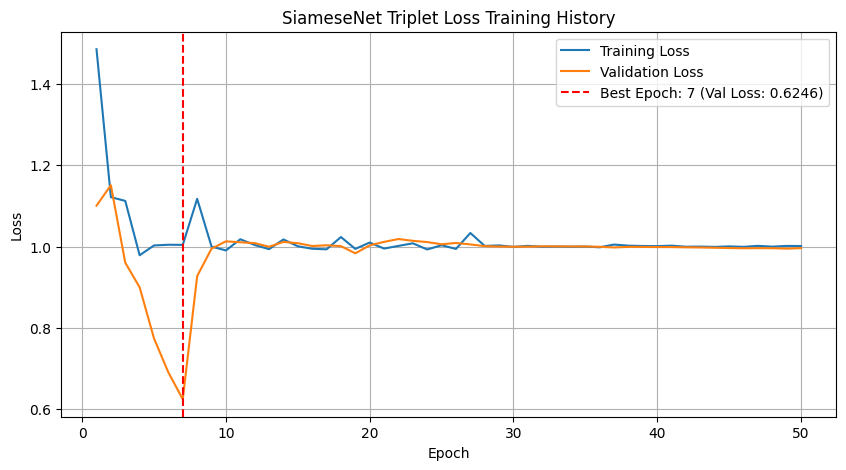

Best validation loss of 0.6246 occurred at epoch 7


In [145]:
if history and 'loss' in history.history and 'val_loss' in history.history:
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, EPOCHS + 1), history.history['loss'], label='Training Loss')
    plt.plot(range(1, EPOCHS + 1), history.history['val_loss'], label='Validation Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("SiameseNet Triplet Loss Training History")
    plt.legend()
    plt.grid(True)
    # Find epoch with minimum validation loss
    best_epoch = np.argmin(history.history['val_loss']) + 1
    min_val_loss = np.min(history.history['val_loss'])
    plt.axvline(best_epoch, color='r', linestyle='--', label=f'Best Epoch: {best_epoch} (Val Loss: {min_val_loss:.4f})')
    plt.legend() # Show legend again to include the line
    plt.show()
    print(f"Best validation loss of {min_val_loss:.4f} occurred at epoch {best_epoch}")
else:
     print("Could not plot history.")

In [146]:
#Choosing weights from epoch manually
chosen_epoch_manual = 30
while chosen_epoch_manual is None:
    try:
        prompt = f"Enter the epoch number whose WEIGHTS you want to use (1-{EPOCHS}, suggested best: {best_epoch}): "
        user_input = input(prompt)
        epoch_val = int(user_input)
        if 1 <= epoch_val <= EPOCHS:
            chosen_epoch_manual = epoch_val
        else: print(f"Invalid epoch number. Please enter 1-{EPOCHS}.")
    except ValueError: print("Invalid input. Please enter an integer.")
print(f"Selected epoch for final model: {chosen_epoch_manual}")

Selected epoch for final model: 30


In [149]:
#Loading Chosen Weights into the Triplet Model
print(f"\nLoading weights from epoch {chosen_epoch_manual} into the triplet model...")
weights_filename = f'model_epoch_{chosen_epoch_manual:03d}.weights.h5'
weights_path = os.path.join('training_checkpoints', weights_filename)

inference_embedding_layer = None # Placeholder

if os.path.exists(weights_path):
    try:
        # Load weights into the existing triplet model instance
        siamese_triplet_model.load_weights(weights_path)
        print(f"Successfully loaded weights from {weights_path} into the triplet training model.")
        # Extract the embedding layer - it now has the chosen weights
        # Use the global 'embedding_layer' instance which is part of 'siamese_triplet_model'
        inference_embedding_layer = embedding_layer # This layer instance inside the triplet model now has the loaded weights
        print("Using the embedding layer with loaded weights.")

    except Exception as e:
        print(f"ERROR loading weights from {weights_path}: {e}")
        import traceback
        traceback.print_exc()
else:
    print(f"ERROR: Weights file not found for epoch {chosen_epoch_manual} at: {weights_path}")



Loading weights from epoch 30 into the triplet model...
Successfully loaded weights from training_checkpoints\model_epoch_030.weights.h5 into the triplet training model.
Using the embedding layer with loaded weights.


### Building and Saving Final Inference Model

In [155]:
#Building and Saving Final Inference Model ---
final_inference_model_path = 'siamese_inference_model.h5'

if inference_embedding_layer:
    print("\nBuilding the final two-input inference model...")

    # Defining input layers for the inference model
    input_image1 = tf.keras.layers.Input(shape=(105, 105, 3), name='input_1')
    input_image2 = tf.keras.layers.Input(shape=(105, 105, 3), name='input_2')

    # Generating embeddings using the chosen embedding layer
    embedding1 = inference_embedding_layer(input_image1)
    embedding2 = inference_embedding_layer(input_image2)

    #Defining distance calculator using L2Dist
    distance_calculator = L2Dist() #

    # Calculate the distance
    distance = distance_calculator([embedding1, embedding2])

    # Define the inference model
    inference_model = tf.keras.models.Model(
        inputs=[input_image1, input_image2],
        outputs=distance,
        name='SiameseInferenceModel'
    )

    inference_model.summary()

    # Save the complete inference model
    try:
        inference_model.save(final_inference_model_path)
        print(f"Successfully saved final inference model to: {final_inference_model_path}")
    except Exception as e:
        print(f"Error saving final inference model: {e}")
        import traceback
        traceback.print_exc()

else:
    print("\nSkipping inference model creation because weights could not be loaded.")


Building the final two-input inference model...


Model: "SiameseInferenceModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_1             │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_2             │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_layer     │ (None, 4096)      │ 38,960,448 │ input_1[0][0],    │
│ (Functional)        │                   │            │ input_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l2_dist_1 (L2Dist)  │ (None, 1)         │          0 │ embedding_layer[… │
│                     │                   │            │ embedding_layer[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

Successfully saved final inference model to: siamese_inference_model.h5


### Real Time Verification

In [ ]:
# --- Verification using the Saved Inference Model ---
print(f"\nAttempting to load inference model: {final_inference_model_path}")
loaded_inference_model = None
if os.path.exists(final_inference_model_path):
     try:
         loaded_inference_model = tf.keras.models.load_model(
             final_inference_model_path,
             custom_objects={'L2Dist': L2Dist} # Add L1Dist if you used that instead
         )
         print("Successfully loaded inference model.")
     except Exception as e:
        print(f"Error loading inference model: {e}")
        import traceback
        traceback.print_exc()

if loaded_inference_model:
    print("\nStarting real-time verification using the loaded inference model...")
    # Create directories if they don't exist
    app_input_dir = os.path.join('application_data', 'input_image')
    app_verify_dir = os.path.join('application_data', 'verification_images')
    os.makedirs(app_input_dir, exist_ok=True)
    os.makedirs(app_verify_dir, exist_ok=True)

    # We need at least one reference image of the anchor person
    verification_files = os.listdir(app_verify_dir)
    if not verification_files:
        print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        print(f"ERROR: No reference images found in {app_verify_dir}.")
        print(f"Please copy at least one image of the anchor person into that directory.")
        print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        reference_image_path = None
    else:
        reference_image_path = os.path.join(app_verify_dir, verification_files[0])
        print(f"Using reference image: {reference_image_path}")
        reference_img_processed = preprocess_for_inference(reference_image_path) 

    #OpenCV Loop for real time verification
    cap = cv2.VideoCapture(0)
    #Tunable verification threshold
    verification_threshold = 0.09
    font = cv2.FONT_HERSHEY_SIMPLEX

    while cap.isOpened() and reference_image_path:
        ret, frame = cap.read()
        if not ret: break
        frame_cropped = frame[100:100+250, 200:200+250].copy()
        cv2.imshow('Verification Window', frame_cropped)

        # Verification Trigger (Press 'v')
        if cv2.waitKey(10) & 0xFF == ord('v'):
            input_image_save_path = os.path.join(app_input_dir, 'input_image.jpg')
            cv2.imwrite(input_image_save_path, frame_cropped)
            print("Input image saved. Running verification...")

            # Preprocess the input webcam image
            input_img_processed = preprocess_for_inference(input_image_save_path)

            # Predict distance using the loaded inference model
            # Input needs to be a list or tuple: [input1, input2]
            predicted_distance = loaded_inference_model.predict([input_img_processed, reference_img_processed], verbose=0)
            distance_value = predicted_distance[0][0] # Extract the scalar distance value

            print(f"  Predicted Distance: {distance_value:.4f}")

            # Compare distance to threshold
            if distance_value < verification_threshold:
                print("  => VERIFIED")
                verified = True
            else:
                print("  => UNVERIFIED")
                verified = False

            # Display result on the frame
            text = "Verified" if verified else "Unverified"
            color = (0, 255, 0) if verified else (0, 0, 255)
            cv2.putText(frame, f"{text} ({distance_value:.2f})", (50, 50), font, 1, color, 2, cv2.LINE_AA)
            cv2.imshow('Verification Window', frame) # Re-show frame with text

        # Quit (Press 'q')
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()
    if not reference_image_path:
        print("Verification loop did not run because no reference image was found.")
else:
    print("Could not load the final inference model. Skipping verification.")


Attempting to load inference model: siamese_inference_model.h5


Successfully loaded inference model.

Starting real-time verification using the loaded inference model...
Using reference image: application_data\verification_images\1aad9531-1ea6-11f0-a85b-04ed33d22284.jpg


In [182]:
# --- Verification using the Saved Inference Model ---
print(f"\nAttempting to load inference model: {final_inference_model_path}")
loaded_inference_model = None
if os.path.exists(final_inference_model_path):
     try:
         loaded_inference_model = tf.keras.models.load_model(
             final_inference_model_path,
             custom_objects={'L2Dist': L2Dist} # Add L1Dist if you used that instead
         )
         print("Successfully loaded inference model.")
     except Exception as e:
        print(f"Error loading inference model: {e}")
        import traceback
        traceback.print_exc()

if loaded_inference_model:
    print("\nStarting real-time verification using the loaded inference model...")
    # Create directories if they don't exist
    app_input_dir = os.path.join('application_data', 'input_image')
    app_verify_dir = os.path.join('application_data', 'verification_images')
    os.makedirs(app_input_dir, exist_ok=True)
    os.makedirs(app_verify_dir, exist_ok=True)

    # We need at least one reference image of the anchor person
    verification_files = os.listdir(app_verify_dir)
    if not verification_files:
        print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        print(f"ERROR: No reference images found in {app_verify_dir}.")
        print(f"Please copy at least one image of the anchor person into that directory.")
        print(f"!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        reference_image_path = None
    else:
        reference_image_path = os.path.join(app_verify_dir, verification_files[0])
        print(f"Using reference image: {reference_image_path}")
        reference_img_processed = preprocess_for_inference(reference_image_path) 

if loaded_inference_model and reference_image_path: 
    print("\nStarting real-time verification...")
    # Verification setup
    app_input_dir = os.path.join('application_data', 'input_image')

    #OpenCV Loop
    cap = cv2.VideoCapture(0)
    #Tunable threshold
    verification_threshold = 0.09 
    font = cv2.FONT_HERSHEY_SIMPLEX

    #State Variables
    last_verified_status = None 
    last_distance = 0.0       

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print("Failed to grab frame")
            break

        frame_display = frame.copy() 
        frame_cropped = frame[100:100+250, 200:200+250].copy()

        key = cv2.waitKey(10) & 0xFF

        #Verification Trigger
        if key == ord('v'):
            input_image_save_path = os.path.join(app_input_dir, 'input_image.jpg')
            cv2.imwrite(input_image_save_path, frame_cropped)
            print("Input image saved. Running verification...")

            input_img_processed = preprocess_for_inference(input_image_save_path)
            predicted_distance = loaded_inference_model.predict([input_img_processed, reference_img_processed], verbose=0)
            distance_value = predicted_distance[0][0]

            print(f"  Predicted Distance: {distance_value:.4f}")

            #Update State Variables
            last_distance = distance_value
            if distance_value < verification_threshold:
                print("  => VERIFIED")
                last_verified_status = True
            else:
                print("  => UNVERIFIED")
                last_verified_status = False
            # --- End State Update ---

        #Drawing Logic (Executed EVERY frame)
        if last_verified_status is not None: # Only draw if verification has been run at least once
            text = "Verified" if last_verified_status else "Unverified"
            color = (0, 255, 0) if last_verified_status else (0, 0, 255)
            # Draw on the display frame
            cv2.putText(frame_display, f"{text} ({last_distance:.2f})", (50,50), font, 1, color, 2, cv2.LINE_AA)
        # --- End Drawing Logic ---

        #Display the frame
        cv2.imshow('Verification Window', frame_display)

        #Quit
        if key == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

else:
    print("Verification prerequisites not met (model or reference image missing).")


Attempting to load inference model: siamese_inference_model.h5


Successfully loaded inference model.

Starting real-time verification using the loaded inference model...
Using reference image: application_data\verification_images\1aad9531-1ea6-11f0-a85b-04ed33d22284.jpg

Starting real-time verification...
Input image saved. Running verification...
  Predicted Distance: 0.0805
  => VERIFIED
Input image saved. Running verification...
  Predicted Distance: 0.1516
  => UNVERIFIED


![image](images/verified.png)

![image](images/unverified.png)

### Model Evaluation

Calculating predicted distances on the validation set using the inference model...
Predicted 45 A-P distances and 45 A-N distances.
Calculating ROC curve to find optimal threshold...
Optimal Distance Threshold based on ROC (closest to top-left): 0.1464

--- Validation Metrics ---
Threshold Used: 0.1464
Accuracy:  0.8889
Precision: 0.9487
Recall:    0.8222
ROC AUC:   0.9674


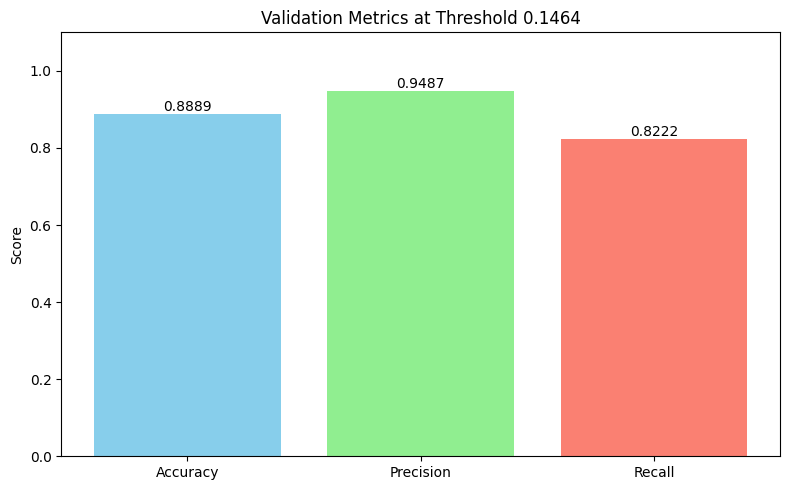

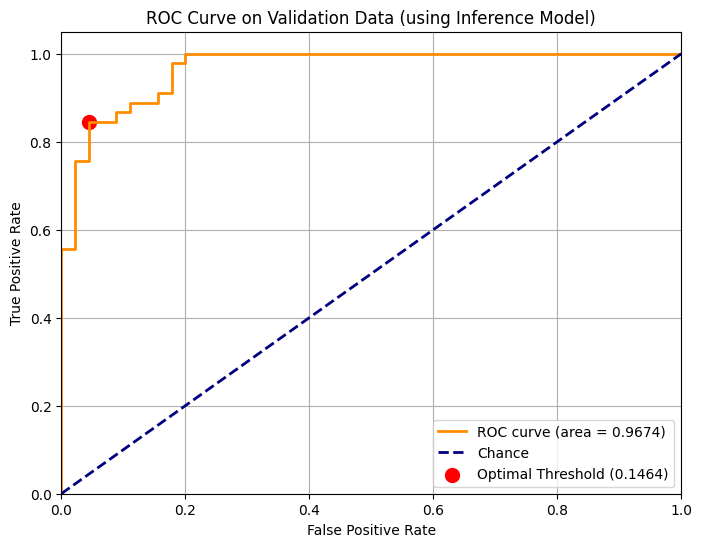

In [188]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_curve, auc

# Proceed only if the model loaded successfully
if loaded_inference_model:
    all_ap_predicted_distances = []
    all_an_predicted_distances = []

    # 1. Get Predicted Distances using the Inference Model
    print("Calculating predicted distances on the validation set using the inference model...")
    for batch_anchor, batch_positive, batch_negative in test_data:
        # Predict distance for Anchor-Positive pairs
        # Input is a list: [input1, input2]
        ap_distances = loaded_inference_model.predict([batch_anchor, batch_positive], verbose=0)
        all_ap_predicted_distances.extend(ap_distances.flatten()) # Flatten to get a list of scalars

        # Predict distance for Anchor-Negative pairs
        an_distances = loaded_inference_model.predict([batch_anchor, batch_negative], verbose=0)
        all_an_predicted_distances.extend(an_distances.flatten()) # Flatten

    all_ap_predicted_distances = np.array(all_ap_predicted_distances)
    all_an_predicted_distances = np.array(all_an_predicted_distances)

    print(f"Predicted {len(all_ap_predicted_distances)} A-P distances and {len(all_an_predicted_distances)} A-N distances.")

    # 2. Create Labels and Combine Predicted Distances
    # Labels: 1 for positive pairs (A-P), 0 for negative pairs (A-N)
    positive_labels = np.ones_like(all_ap_predicted_distances)
    negative_labels = np.zeros_like(all_an_predicted_distances)

    all_labels = np.concatenate([positive_labels, negative_labels])
    all_predicted_distances = np.concatenate([all_ap_predicted_distances, all_an_predicted_distances])

    # 3. Find Optimal Threshold using ROC Curve (based on predicted distances)
    print("Calculating ROC curve to find optimal threshold...")
    # Note: roc_curve expects scores where higher indicates positive class.
    # Since LOWER distance means positive (match), we need to invert the scores/distances.
    # We use -all_predicted_distances so higher negative distance (closer to 0) is treated as positive score.
    fpr, tpr, thresholds_roc = roc_curve(all_labels, -all_predicted_distances)
    roc_auc = auc(fpr, tpr)

    # Find the threshold corresponding to the best point on ROC curve
    optimal_idx = np.argmax(tpr - fpr)
    # The threshold from roc_curve is based on the inverted score (-distance).
    # We need to convert it back to a distance threshold.
    optimal_distance_threshold = -thresholds_roc[optimal_idx]
    print(f"Optimal Distance Threshold based on ROC (closest to top-left): {optimal_distance_threshold:.4f}")

    # 4. Make Predictions based on the optimal distance threshold
    # Prediction is 1 if distance < threshold, else 0
    y_pred_labels = (all_predicted_distances < optimal_distance_threshold).astype(int)

    # 5. Calculate Metrics
    precision = precision_score(all_labels, y_pred_labels)
    recall = recall_score(all_labels, y_pred_labels)
    accuracy = accuracy_score(all_labels, y_pred_labels)

    print("\n--- Validation Metrics ---")
    print(f"Threshold Used: {optimal_distance_threshold:.4f}")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"ROC AUC:   {roc_auc:.4f}")

    # 6. Plotting (Same plotting code as before)
    # Bar chart
    metrics_names = ['Accuracy', 'Precision', 'Recall']
    metrics_values = [accuracy, precision, recall]
    plt.figure(figsize=(8, 5))
    bars = plt.bar(metrics_names, metrics_values, color=['skyblue', 'lightgreen', 'salmon'])
    plt.ylabel("Score"); plt.title(f"Validation Metrics at Threshold {optimal_distance_threshold:.4f}"); plt.ylim(0, 1.1)
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.4f}', va='bottom', ha='center')
    plt.tight_layout(); plt.show()

    # ROC Curve Plot
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance')
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', s=100, label=f'Optimal Threshold ({optimal_distance_threshold:.4f})')
    plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05]); plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title('ROC Curve on Validation Data (using Inference Model)'); plt.legend(loc="lower right"); plt.grid(True); plt.show()

The model performs very well!

                                                                                                                                            ~ Gregoritsch3